   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 11.4 MB/s eta 0:00:00


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Enter the subject name: sex
Enter the subject code: sex


<ipython-input-1-b369e558a70f>:88: RuntimeWarning: coroutine 'CommentForest.replace_more' was never awaited
  submission.comments.replace_more(limit=None)


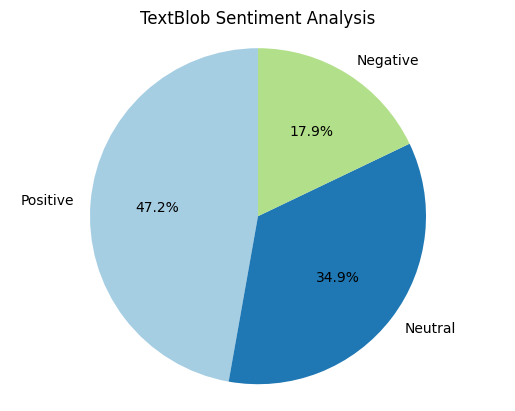

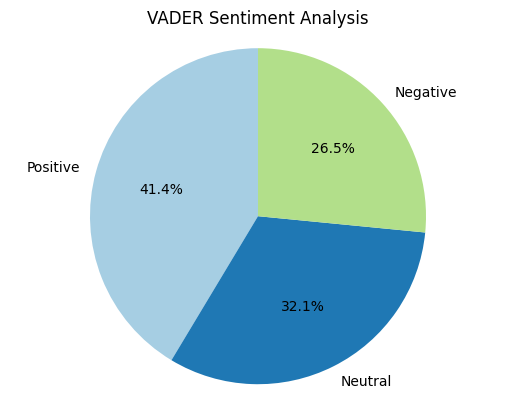

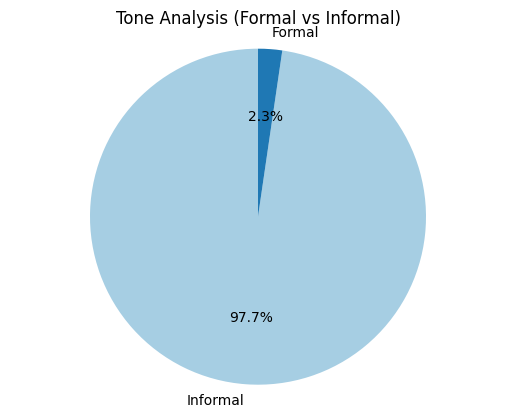

Results exported to async_sentiment_analysis_results.xlsx with pie charts embedded.


In [ ]:
!pip install asyncpraw

import asyncio
import asyncpraw
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
import nltk
from openpyxl import load_workbook
from openpyxl.drawing.image import Image  # To insert images in Excel

nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
vader_analyzer = SentimentIntensityAnalyzer()

def clean_text(text):
    # Remove @mentions, # symbols, RT, hyperlinks, and colons
    return re.sub(r'@[A-Za-z0–9]+|#|RT[\s]+|https?:\/\/\S+|:', '', text)

def get_sentiment_vader(text):
    # Get the compound score from VADER
    compound_score = vader_analyzer.polarity_scores(text)['compound']
    return "Positive" if compound_score >= 0.05 else "Negative" if compound_score <= -0.05 else "Neutral"

def get_insight(score):
    return "Negative" if score < 0 else "Neutral" if score == 0 else "Positive"

def detect_tone(text):
    informal_keywords = [
        "wanna", "gonna", "lol", "u", "omg", "dunno", "ain't", "gimme", "guyz", "lmao", "lmfao",
        "wassup", "btw", "idk", "lemme", "gotcha", "cuz", "bro", "dude", "cool", "awesome"
    ]

    # Detect informal tone based on keywords
    if any(word in text.lower() for word in informal_keywords):
        return "Informal"

    # Basic heuristic: longer sentences with longer words often indicate a formal tone
    word_count = len(text.split())
    avg_word_length = sum(len(word) for word in text.split()) / word_count if word_count > 0 else 0

    if word_count > 10:  # Customizable thresholds
        return "Formal"

    return "Informal"

# Plotting a pie chart and saving it to file
def save_pie_chart(labels, sizes, title, file_name, display_chart=False):
    fig, ax = plt.subplots()
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(title)

    # Save the pie chart as an image file
    plt.savefig(file_name)

    # Optionally display the chart
    if display_chart:
        plt.show()

    # Close the plot to avoid overlap when generating multiple charts
    plt.close()

# Define user agent and authenticate asynchronously
async def reddit_sentiment_analysis(subject_name, subject_code):
    user_agent = "asyncpraw_SA"

    reddit = asyncpraw.Reddit(
        client_id="pwyCbnKLNoN6g4E4VIHRJw",
        client_secret="v1aOBmrFZ1p5caXrisgmO2oHzLRILg",
        user_agent=user_agent
    )

    subreddit_name = "india"
    subreddit = await reddit.subreddit(subreddit_name)

    # Creating lists for storing scraped data
    comments_list = []

    # Creating search query
    search_q = f"{subject_name} {subject_code}"

    async for submission in subreddit.search(search_q, limit=10):  # Adjust the limit as needed
        await submission.load()
        submission.comments.replace_more(limit=None)

        for comment in submission.comments.list():
            # Skip MoreComments objects
            if isinstance(comment, asyncpraw.models.MoreComments):
                continue

            # Filtering comments based on subject_name and subject_code
            if subject_name not in submission.title and subject_code not in submission.title and \
               subject_name not in comment.body and subject_code not in comment.body:
                continue

            comments_list.append(clean_text(comment.body))

    # Create a DataFrame with cleaned comments
    df = pd.DataFrame({'Comments': comments_list})

    # Analyze sentiment with TextBlob
    df['Subjectivity'] = df['Comments'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
    df['Polarity'] = df['Comments'].apply(lambda x: TextBlob(x).sentiment.polarity)
    df['Insight_TextBlob'] = df['Polarity'].apply(get_insight)

    # Analyze sentiment with VADER
    df['Sentiment_VADER'] = df['Comments'].apply(get_sentiment_vader)

    # Detect tone (formal vs informal)
    df['Tone'] = df['Comments'].apply(detect_tone)

    # Count for TextBlob sentiment
    textblob_counts = df['Insight_TextBlob'].value_counts()
    # Count for VADER sentiment
    vader_counts = df['Sentiment_VADER'].value_counts()
    # Count for Tone (Formal vs Informal)
    tone_counts = df['Tone'].value_counts()

    # Save Pie Charts as images, and display them
    save_pie_chart(textblob_counts.index.tolist(), textblob_counts.values.tolist(), "TextBlob Sentiment Analysis", "textblob_sentiment.png", display_chart=True)
    save_pie_chart(vader_counts.index.tolist(), vader_counts.values.tolist(), "VADER Sentiment Analysis", "vader_sentiment.png", display_chart=True)
    save_pie_chart(tone_counts.index.tolist(), tone_counts.values.tolist(), "Tone Analysis (Formal vs Informal)", "tone_analysis.png", display_chart=True)

    # Save DataFrame to Excel file
    excel_file_path = 'async_sentiment_analysis_results.xlsx'
    df.to_excel(excel_file_path, index=False)

    # Open the Excel file and insert images
    wb = load_workbook(excel_file_path)
    ws = wb.active

    # Insert pie charts into the Excel file
    img_textblob = Image('textblob_sentiment.png')
    img_vader = Image('vader_sentiment.png')
    img_tone = Image('tone_analysis.png')

    # Adjust the position of the images in the sheet (customize the rows/columns as per your need)
    ws.add_image(img_textblob, 'G2')  # Position the image starting at cell G2
    ws.add_image(img_vader, 'G20')  # Position the image starting at cell G20
    ws.add_image(img_tone, 'G38')  # Position the image starting at cell G38

    # Save the workbook with the images
    wb.save(excel_file_path)

    print(f"Results exported to {excel_file_path} with pie charts embedded.")

# Running the async function
subject_name = input("Enter the subject name: ")
subject_code = input("Enter the subject code: ")

# Run the async function using asyncio
await reddit_sentiment_analysis(subject_name, subject_code)


In [ ]:
from google.colab import files
files.download('async_sentiment_analysis_results.xlsx')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>